In [3]:
import pandas as pd

df = pd.read_csv("/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/shakespeare_plays.csv")


In [4]:
df.info()

df.columns
df = df.drop(columns=['Unnamed: 0'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108093 entries, 0 to 108092
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  108093 non-null  int64 
 1   play_name   108093 non-null  object
 2   genre       108093 non-null  object
 3   character   108093 non-null  object
 4   act         108093 non-null  int64 
 5   scene       108093 non-null  int64 
 6   sentence    108093 non-null  int64 
 7   text        108093 non-null  object
 8   sex         108093 non-null  object
dtypes: int64(4), object(5)
memory usage: 7.4+ MB


/var/folders/8d/41krvnl108742n4xzr8g0zj80000gn/T/ipykernel_19382/2202544573.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, ax=axes[0], palette="pastel")
/var/folders/8d/41krvnl108742n4xzr8g0zj80000gn/T/ipykernel_19382/2202544573.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_characters.values, y=top_characters.index, ax=axes[1], palette="muted")


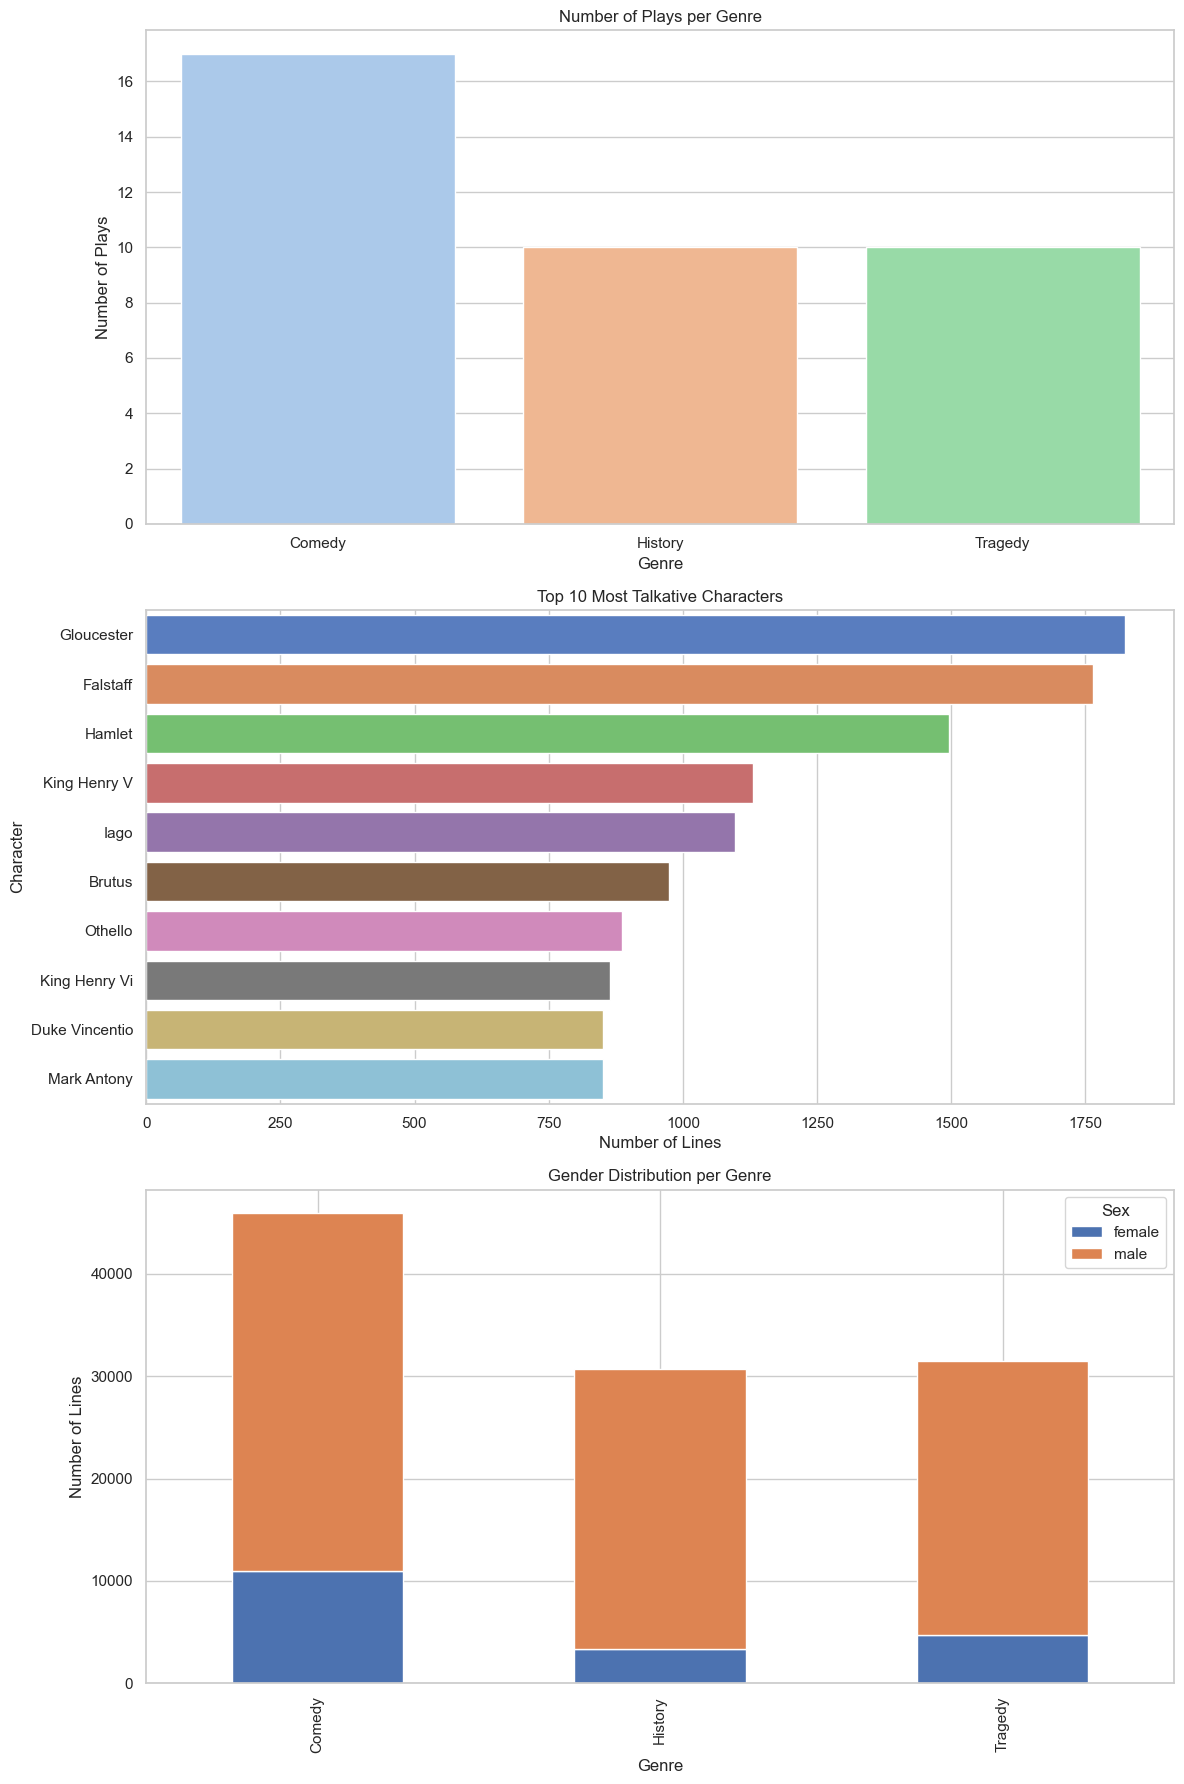

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

genre_counts = df[['play_name', 'genre']].drop_duplicates().genre.value_counts()

top_characters = df['character'].value_counts().head(10)

gender_by_genre = df.groupby(['genre', 'sex'])['character'].count().unstack().fillna(0)

hamlet_df = df[df['play_name'] == "Hamlet"]
hamlet_scene_counts = hamlet_df.groupby(['act', 'scene'])['text'].count().reset_index()

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

sns.barplot(x=genre_counts.index, y=genre_counts.values, ax=axes[0], palette="pastel")
axes[0].set_title("Number of Plays per Genre")
axes[0].set_ylabel("Number of Plays")
axes[0].set_xlabel("Genre")

sns.barplot(x=top_characters.values, y=top_characters.index, ax=axes[1], palette="muted")
axes[1].set_title("Top 10 Most Talkative Characters")
axes[1].set_xlabel("Number of Lines")
axes[1].set_ylabel("Character")

gender_by_genre.plot(kind='bar', stacked=True, ax=axes[2])
axes[2].set_title("Gender Distribution per Genre")
axes[2].set_ylabel("Number of Lines")
axes[2].set_xlabel("Genre")
axes[2].legend(title='Sex')

plt.tight_layout()
plt.show()


Step 2: Prepare Dataset for Sentiment Analysis

We want to analyze the emotional flow of each character, especially in relation to:

- the play they appear in,
- the genre (comedy or tragedy),
- and how their sentiment shifts across acts and scenes.

In [6]:
grouped_df = df.groupby(
    ['play_name', 'genre', 'character', 'act', 'scene']
)['text'].apply(lambda x: ' '.join(x)).reset_index()

grouped_df.head(10)

,play_name,genre,character,act,scene,text
0,A Midsummer Night's Dream,Comedy,All,1,2,"That would hang us, every mother's son."
1,A Midsummer Night's Dream,Comedy,All,3,1,Where shall we go?
2,A Midsummer Night's Dream,Comedy,Bottom,1,2,"You were best to call them generally, man by m..."
3,A Midsummer Night's Dream,Comedy,Bottom,3,1,"Are we all met? Peter Quince,-- There are thin..."
4,A Midsummer Night's Dream,Comedy,Bottom,4,1,Where's Peaseblossom? Scratch my head Peaseblo...
5,A Midsummer Night's Dream,Comedy,Bottom,4,2,Where are these lads? where are these hearts? ...
6,A Midsummer Night's Dream,Comedy,Bottom,5,1,[Starting up] No assure you; the wall is down...
7,A Midsummer Night's Dream,Comedy,Cobweb,3,1,And I. Hail! Cobweb.
8,A Midsummer Night's Dream,Comedy,Cobweb,4,1,Ready.
9,A Midsummer Night's Dream,Comedy,Demetrius,1,1,"Relent, sweet Hermia: and, Lysander, yield Thy..."


In [82]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Tokenize, lowercase, remove stopwords and punctuation, lemmatize
def preprocess_and_tokenize(text):
    text = text.lower()
    tokens = word_tokenize(text)
    return [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and word not in string.punctuation
    ]

# Apply to each group
grouped_df['tokens'] = grouped_df['text'].apply(preprocess_and_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/elifakdeniz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elifakdeniz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elifakdeniz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Here we see in character column info as: All,Bottom etc.. these means group of characters speak together, like a chorus, soldiers, or background actors. These can harm character-based analysis in both sentiment and network.

It creates one row per character per scene.
All the lines spoken by that character in that scene are combined into one long string in the text column.
Especially based upon the Lexicon or Roberta emotion models that we've seen in our ntoebooks.

In [83]:
df['character'].unique()

array(['Countess', 'Bertram', 'Lafeu', 'Helena', 'Parolles', 'Page',
       'King', 'First Lord', 'Second Lord', 'Steward', 'Clown', 'Both',
       'All', 'Fourth Lord', 'Duke', 'First Gentleman',
       'Second Gentleman', 'Widow', 'Diana', 'Mariana', 'First Soldier',
       'Second Soldier', 'Servant', 'Gentleman', 'Orlando', 'Adam',
       'Oliver', 'Dennis', 'Charles', 'Celia', 'Rosalind', 'Touchstone',
       'Le Beau', 'Duke Frederick', 'Duke Senior', 'Amiens', 'Corin',
       'Silvius', 'Jaques', 'Audrey', 'Sir Oliver Martext', 'Phebe',
       'A Lord', 'Forester', 'William', 'First Page', 'Second Page',
       'Hymen', 'Jaques De Boys', 'Aegeon', 'Duke Solinus', 'Gaoler',
       'First Merchant', 'Of Syracuse', 'Dromio Of Syracuse',
       'Dromio Of Ephesus', 'Adriana', 'Luciana', 'Of Ephesus',
       'Balthazar', 'Luce', 'Antipholus', 'Angelo', 'Second Merchant',
       'Officer', 'Courtezan', 'Pinch', 'Aemelia', 'Queen',
       'Posthumus Leonatus', 'Imogen', 'Cymbeline', 'P

In [84]:
df['character'].value_counts().head(50)

character
Gloucester            1824
Falstaff              1764
Hamlet                1495
King Henry V          1130
Iago                  1098
Brutus                 975
Othello                887
King Henry Vi          865
Duke Vincentio         851
Mark Antony            851
Timon                  824
Queen Margaret         814
Prince Henry           777
Clown                  761
King Richard Ii        758
King Lear              752
Warwick                735
Titus Andronicus       722
Macbeth                718
Helena                 702
Prospero               695
York                   693
Leontes                692
Cleopatra              686
Portia                 681
Coriolanus             680
Rosalind               677
King Henry Iv          664
Buckingham             632
Romeo                  612
Pericles               609
Imogen                 605
Biron                  599
Menenius               589
Petruchio              587
Hotspur                562
Suffolk           

So we did character frequency analyses to be able to descriminate non-individual parts. This shows the most common characters.

In [85]:
group_labels = [
    'All', 'Both', 'Attendants', 'Citizens', 'Soldiers', 'Messenger',
    'Servant', 'Servants', '1st Citizen', '2nd Citizen', 'Chorus',
    'First Soldier', 'Second Soldier', 'A Lord', 'A Messenger'
]
filtered_grouped_df = grouped_df[~grouped_df['character'].isin(group_labels)].copy()

filtered_grouped_df.head(30)

,play_name,genre,character,act,scene,text,tokens
2,A Midsummer Night's Dream,Comedy,Bottom,1,2,"You were best to call them generally, man by m...","[best, call, generally, man, man, according, s..."
3,A Midsummer Night's Dream,Comedy,Bottom,3,1,"Are we all met? Peter Quince,-- There are thin...","[met, peter, quince, --, thing, comedy, pyramu..."
4,A Midsummer Night's Dream,Comedy,Bottom,4,1,Where's Peaseblossom? Scratch my head Peaseblo...,"['s, peaseblossom, scratch, head, peaseblossom..."
5,A Midsummer Night's Dream,Comedy,Bottom,4,2,Where are these lads? where are these hearts? ...,"[lad, heart, master, discourse, wonder, ask, t..."
6,A Midsummer Night's Dream,Comedy,Bottom,5,1,[Starting up] No assure you; the wall is down...,"[starting, assure, wall, parted, father, pleas..."
7,A Midsummer Night's Dream,Comedy,Cobweb,3,1,And I. Hail! Cobweb.,"[i., hail, cobweb]"
8,A Midsummer Night's Dream,Comedy,Cobweb,4,1,Ready.,[ready]
9,A Midsummer Night's Dream,Comedy,Demetrius,1,1,"Relent, sweet Hermia: and, Lysander, yield Thy...","[relent, sweet, hermia, lysander, yield, thy, ..."
10,A Midsummer Night's Dream,Comedy,Demetrius,2,1,"I love thee not, therefore pursue me not. Wher...","[love, thee, therefore, pursue, lysander, fair..."
11,A Midsummer Night's Dream,Comedy,Demetrius,2,2,"I charge thee, hence, and do not haunt me thus...","[charge, thee, hence, haunt, thus, stay, thy, ..."


From now on we move analysis with filtered version.

“Both” is not a unique named character, and we don’t know who exactly is speaking when it appears. It’s a placeholder, not an identity.

"Both" usually refers to two characters speaking together, like:

Two lovers finishing each other's thoughts
Two guards agreeing on something
Two random citizens responding at once
"Both" just adds confusion, since it doesn’t tie the speech or interaction back to one person.

In [86]:
pip install transformers torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


Ref: https://huggingface.co/j-hartmann/emotion-english-distilroberta-base

In [87]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.special import softmax
from tqdm import tqdm

model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
labels = model.config.id2label

def get_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**inputs)
    scores = softmax(output.logits.numpy()[0])
    max_idx = scores.argmax()
    return labels[max_idx], round(float(scores[max_idx]), 3)

tqdm.pandas()
filtered_grouped_df['emotion'], filtered_grouped_df['confidence'] = zip(*filtered_grouped_df['text'].progress_apply(get_emotion))

filtered_grouped_df['short_text'] = filtered_grouped_df['text'].str.slice(0, 150) + "..."

filtered_grouped_df[['play_name', 'character', 'act', 'scene', 'short_text', 'emotion', 'confidence']].head(10)


100%|███████████████████████████████████████| 3772/3772 [16:17<00:00,  3.86it/s]


,play_name,character,act,scene,short_text,emotion,confidence
2,A Midsummer Night's Dream,Bottom,1,2,"You were best to call them generally, man by m...",neutral,0.339
3,A Midsummer Night's Dream,Bottom,3,1,"Are we all met? Peter Quince,-- There are thin...",fear,0.945
4,A Midsummer Night's Dream,Bottom,4,1,Where's Peaseblossom? Scratch my head Peaseblo...,anger,0.421
5,A Midsummer Night's Dream,Bottom,4,2,Where are these lads? where are these hearts? ...,neutral,0.774
6,A Midsummer Night's Dream,Bottom,5,1,[Starting up] No assure you; the wall is down...,neutral,0.277
7,A Midsummer Night's Dream,Cobweb,3,1,And I. Hail! Cobweb....,joy,0.507
8,A Midsummer Night's Dream,Cobweb,4,1,Ready....,neutral,0.950
9,A Midsummer Night's Dream,Demetrius,1,1,"Relent, sweet Hermia: and, Lysander, yield Thy...",anger,0.568
10,A Midsummer Night's Dream,Demetrius,2,1,"I love thee not, therefore pursue me not. Wher...",anger,0.785
11,A Midsummer Night's Dream,Demetrius,2,2,"I charge thee, hence, and do not haunt me thus...",fear,0.970


In this section, we applied the j-hartmann/emotion-english-distilroberta-base model to detect the dominant emotions expressed in grouped character lines from A Midsummer Night's Dream. The model processes each text input, predicts the most likely emotion category. We used a custom function get_emotion() to tokenize and classify the input text, and we stored the results in two new columns:

emotion: The predicted emotion label
score: The corresponding prediction score from the model (between 0 and 1)
Abow is a preview of the output.
This output offers a first glimpse into the emotional tone of character speech, allowing us to explore patterns such as:

Which characters express more anger or fear?
How emotions change across acts or scenes?
Are certain characters more emotionally expressive than others?
These questions can guide further visualization and analysis in the next steps. Since here I did a big jump with trial and the workflow goes apparently smoothly:

1. Split Data by Genre


In [88]:
filtered_grouped_df['genre'].unique()

array(['Comedy', 'Tragedy', 'History'], dtype=object)

In [89]:
comedy_plays = filtered_grouped_df[filtered_grouped_df['genre'] == 'Comedy']['play_name'].unique()
tragedy_plays = filtered_grouped_df[filtered_grouped_df['genre'] == 'Tragedy']['play_name'].unique()

comedy_plays = sorted(comedy_plays)
tragedy_plays = sorted(tragedy_plays)

max_len = max(len(comedy_plays), len(tragedy_plays))
comedy_plays += [''] * (max_len - len(comedy_plays))
tragedy_plays += [''] * (max_len - len(tragedy_plays))

genre_table = pd.DataFrame({
    'Comedies': comedy_plays,
    'Tragedies': tragedy_plays
})

genre_table


,Comedies,Tragedies
0,A Midsummer Night's Dream,Antony and Cleopatra
1,All's Well That Ends Well,Coriolanus
2,As You Like It,Hamlet
3,Cymbeline,Julius Caesar
4,Love's Labours Lost,King Lear
5,Measure for Measure,Macbeth
6,Much Ado About Nothing,Othello
7,"Pericles, Prince of Tyre",Romeo and Juliet
8,Taming of the Shrew,Timon of Athens
9,The\nMerry Wives of Windsor,Titus Andronicus


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_emotion_flow(play_name, df):
    """
    Plots emotion resolution scene by scene for the top 3 characters in a specific play.

    Parameters:
    - play_name (str): Name of the play (exact match to 'play_name' in dataframe)
    - df (DataFrame): Your emotion-labeled dataframe (filtered_grouped_df)
    """
    play_df = df[df['play_name'] == play_name]

    if play_df.empty:
        print(f"No data found for play: {play_name}")
        return

    top_chars = play_df['character'].value_counts().head(3).index.tolist()
    char_df = play_df[play_df['character'].isin(top_chars)]

    scene_emotions = (
        char_df.groupby(['character', 'act', 'scene'])['emotion']
        .agg(lambda x: x.mode()[0] if not x.mode().empty else "neutral")
        .reset_index()
    )

    scene_emotions['scene_order'] = scene_emotions['act'] * 10 + scene_emotions['scene']
    scene_emotions = scene_emotions.sort_values(by='scene_order')
    scene_emotions['act_scene'] = scene_emotions['act'].astype(str) + '.' + scene_emotions['scene'].astype(str)

    plt.figure(figsize=(15, 7))
    sns.lineplot(
        data=scene_emotions,
        x='act_scene',
        y='emotion',
        hue='character',
        marker='o',
        markersize=8,
        linewidth=2
    )
    plt.title(f"Emotion Flow of Top Characters in '{play_name}'", fontsize=14)
    plt.xlabel("Act.Scene", fontsize=12)
    plt.ylabel("Emotion", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Character", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


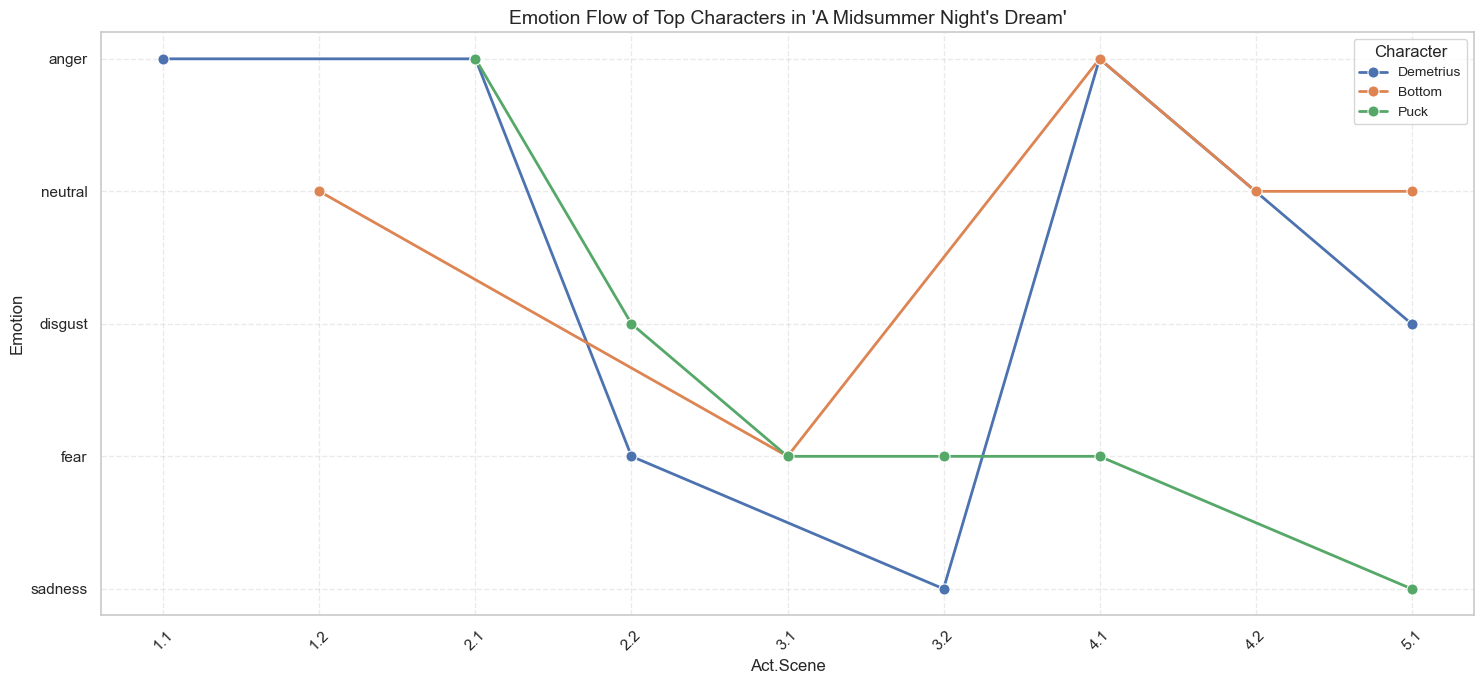

In [91]:
plot_emotion_flow("A Midsummer Night's Dream", filtered_grouped_df)

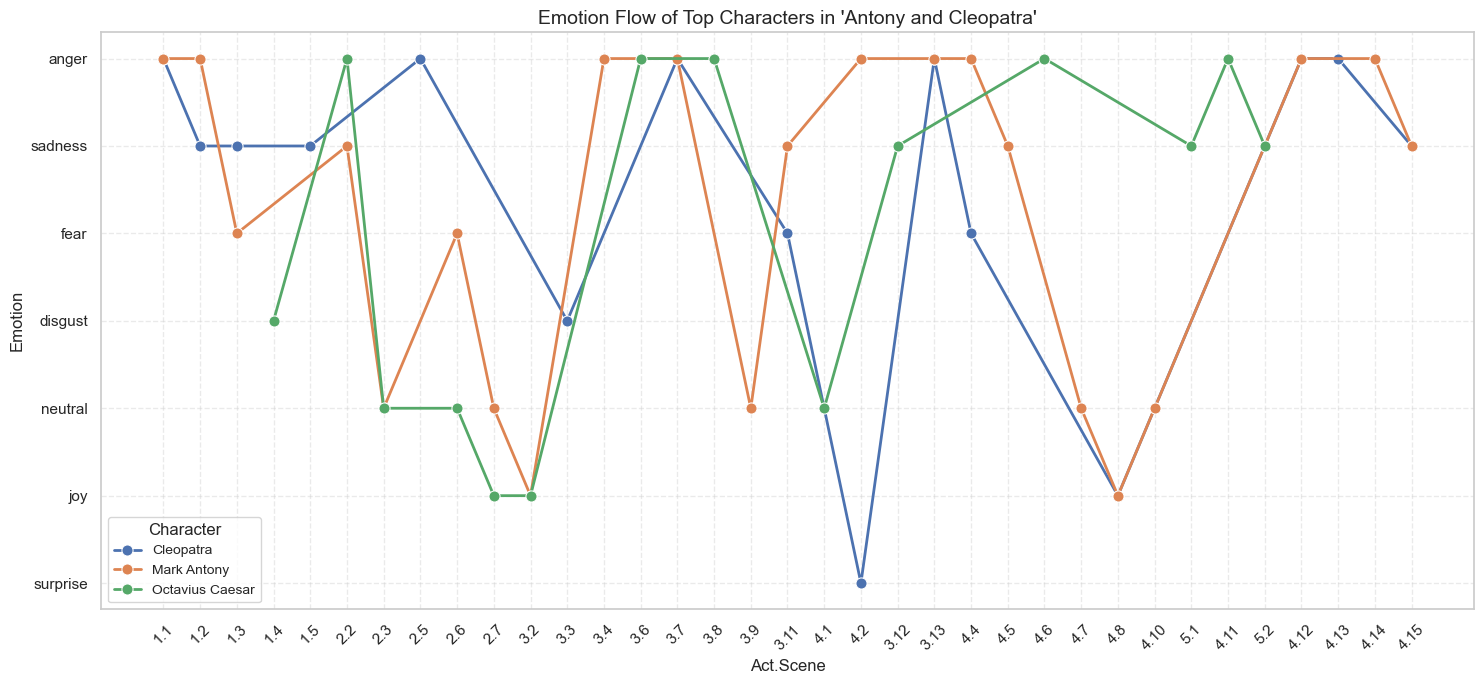

In [92]:
plot_emotion_flow("Antony and Cleopatra", filtered_grouped_df)

Generating Emotion Count Table

 Define a Function to Get the Emotion Summary for One Play

In [93]:
def get_emotion_summary(df, play_name):
    """
    Returns a table of emotion counts per act for top 3 characters in a given play.
    """
    play_df = df[df['play_name'] == play_name]

    if play_df.empty:
        print(f"No data found for play: {play_name}")
        return pd.DataFrame()

    top_chars = play_df['character'].value_counts().head(3).index.tolist()
    char_df = play_df[play_df['character'].isin(top_chars)]

    summary = (
        char_df
        .groupby(['act', 'character', 'emotion'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )

    summary.insert(0, 'play_name', play_name)
    return summary


In [94]:
def summarize_genre_emotions(df, genre_name):
    """
    Builds a full emotion summary table for all plays in a given genre.
    """
    genre_df = df[df['genre'] == genre_name]
    play_names = genre_df['play_name'].unique()

    summary_tables = []
    for play in play_names:
        summary = get_emotion_summary(df, play)
        if not summary.empty:
            summary_tables.append(summary)

    full_summary = pd.concat(summary_tables, ignore_index=True)
    return full_summary


In [95]:
comedy_emotion_table = summarize_genre_emotions(filtered_grouped_df, "Comedy")
tragedy_emotion_table = summarize_genre_emotions(filtered_grouped_df, "Tragedy")


In [96]:
import pandas as pd

comedy_emotion_table.head()
comedy_emotion_table.to_csv("comedy_emotion_table.csv", index=False)
tragedy_emotion_table.to_csv("tragedy_emotion_table.csv", index=False)


In [97]:
comedy_emotion_table = summarize_genre_emotions(filtered_grouped_df, "Comedy")
comedy_emotion_table.head()

emotion,play_name,act,character,anger,disgust,fear,neutral,sadness,joy,surprise
0,A Midsummer Night's Dream,1,Bottom,0,0.0,0.0,1,0.0,NaN,NaN
1,A Midsummer Night's Dream,1,Demetrius,1,0.0,0.0,0,0.0,NaN,NaN
2,A Midsummer Night's Dream,2,Demetrius,1,0.0,1.0,0,0.0,NaN,NaN
3,A Midsummer Night's Dream,2,Puck,1,1.0,0.0,0,0.0,NaN,NaN
4,A Midsummer Night's Dream,3,Bottom,0,0.0,1.0,0,0.0,NaN,NaN


In [98]:
tragedy_emotion_table = summarize_genre_emotions(filtered_grouped_df, "Tragedy")
tragedy_emotion_table.head()

emotion,play_name,act,character,anger,disgust,fear,joy,neutral,sadness,surprise
0,Antony and Cleopatra,1,Cleopatra,1,0.0,0,0.0,0,3,0.0
1,Antony and Cleopatra,1,Mark Antony,2,0.0,1,0.0,0,0,0.0
2,Antony and Cleopatra,1,Octavius Caesar,0,1.0,0,0.0,0,0,0.0
3,Antony and Cleopatra,2,Cleopatra,1,0.0,0,0.0,0,0,0.0
4,Antony and Cleopatra,2,Mark Antony,0,0.0,1,0.0,2,1,0.0


In [100]:
comedy_emotion_table.to_excel("comedy_emotion_summary2.xlsx", index=False)
tragedy_emotion_table.to_excel("tragedy_emotion_summary2.xlsx", index=False)